In [1]:
import noise
from scipy.interpolate import UnivariateSpline as spline
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from mpl_toolkits.mplot3d import axes3d, Axes3D 
import matplotlib.patches as patches
import random
%matplotlib inline

In [2]:
x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
y = np.sin(x)
tck = interpolate.splrep(x, y, s=0)
xnew = np.arange(0,2*np.pi,np.pi/50)
ynew = interpolate.splev(xnew, tck, der=0)

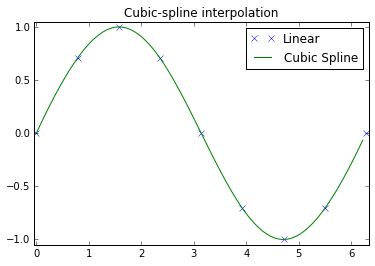

In [3]:
plt.figure()
plt.plot(x, y, 'x', xnew, ynew)
plt.legend(['Linear', 'Cubic Spline'])
plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation')


In [4]:
def draw_derivate(x, tck):
    y =  interpolate.splev(x, tck)
    der_value = interpolate.splev(x, tck, der=1)
    dx = 0.2
    newx = [x-dx, x+dx]
    newy = [y-dx*der_value, y+dx*der_value]
    plt.plot(newx, newy, 'r-', lw=2)
    plt.plot(x, y, 'rx',)
    


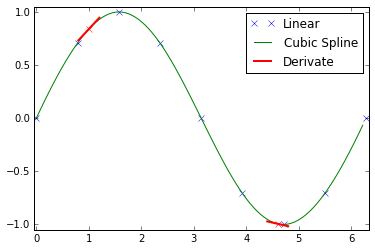

In [5]:
plt.plot(x, y, 'x', xnew, ynew)
draw_derivate(1, tck)
draw_derivate(4.6, tck)
plt.legend(['Linear', 'Cubic Spline', 'Derivate'])
plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.show()

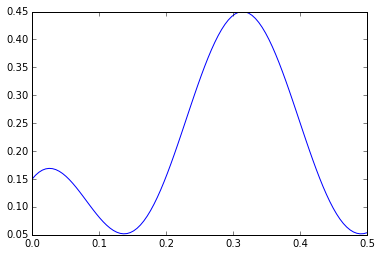

In [6]:
terrainx =  np.linspace(0, 0.5, 30)
terrainy = 0.3*(np.sin(terrainx*5) + 0.5*np.cos(terrainx*20))
tck = interpolate.splrep(terrainx, terrainy, s=0)
tckx = np.linspace(0, 0.5, 100)
tcky = interpolate.splev(tckx, tck)
plt.plot(tckx, tcky)
plt.show()

In [7]:
def plot_3d_surface_multi_azim(X, Y, Z, xlab="", ylab="", zlab=""):
    fig = plt.figure(figsize=(16, 16))
    for i in range(1,5):
        ax = fig.add_subplot(2,2, i, projection='3d')
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        ax.set_zlabel(zlab)
        ax.plot_surface(X, Y, Z)
        ax.view_init(azim=20 + 90*i)
    plt.show()
    

In [8]:
range(1,4)

[1, 2, 3]

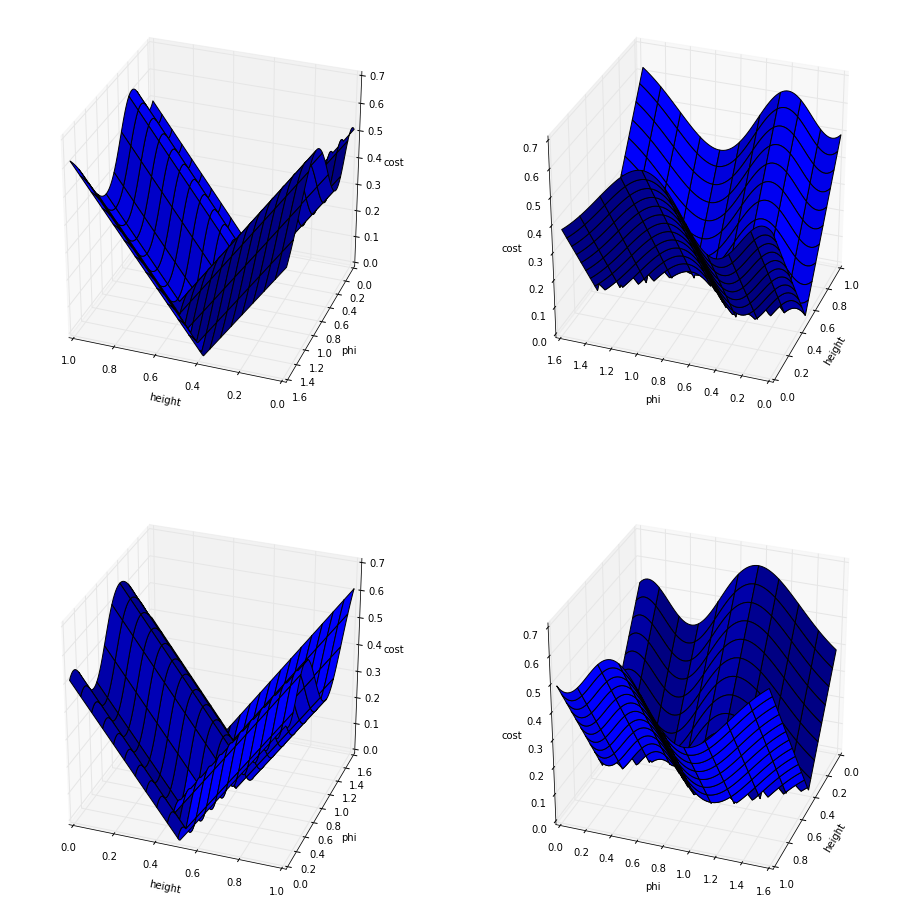

In [9]:
phi = np.linspace(0, np.pi/2, 100)
h = np.linspace(0, 1, 200)
arm_length = 0.36
X, Y = np.meshgrid(h, phi)
cost = lambda height, angle: np.abs(height - arm_length*np.cos(angle) -  interpolate.splev( arm_length*np.sin(angle), tck))
zs = np.array([cost(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

plot_3d_surface_multi_azim(X, Y, Z, xlab="height", ylab="phi", zlab="cost")

In [10]:
#min_index = np.argmin(Z)
#h_min =  X.ravel()[min_index]
#phi_min =  Y.ravel()[min_index]
#plt.plot(tckx, tcky)
#min_point = (np.sin(phi_min)*arm_length, h_min-arm_length*np.cos(phi_min))
#plt.plot(min_point[0], min_point[1], 'ro', markersize=3)
#arm_begin = (min_point[0] - arm_length*np.sin(h_min), min_point[1] + arm_length*np.cos(h_min) )
#plt.plot([min_point[0], arm_begin[0]], [min_point[1], arm_begin[1]], 'r-', markersize=3)
#plt.show()

It's hard to use the optimization approach because requirements regarding the arm-terrain collision cannot be written easily.
let's try with the discrete iterative method

In [11]:
def draw_rect(ax, x, y, w, h):
    ax.add_patch(
    patches.Rectangle(
        (x, y),   # (x,y)
        w,          # width
        h,          # height
        fill=False
        )
    )
def draw_heightmap(ax, x, y):
    dx = x[1] - x[0]
    for i in range(0, len(x)):
        top_n = np.floor(y[i]/dx)
        for n in range(0, int(top_n)):
        #for n in range(0, 4):
               draw_rect(ax, dx*i, n*dx, dx, dx)
        draw_rect(ax, dx*i, top_n*dx, dx, (y[i]-top_n*dx))

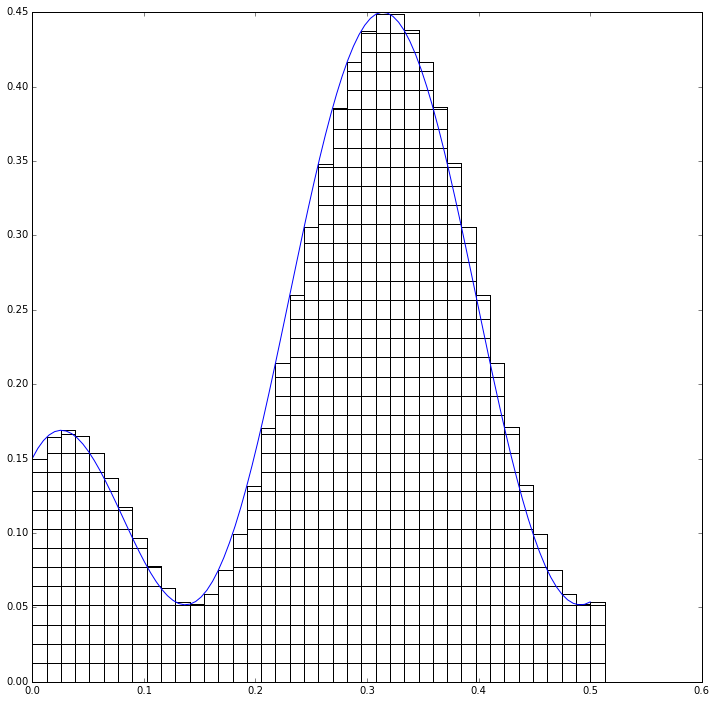

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = plt.gca()
heightmapx = np.linspace(0, 0.5, 40)
heightmapy = interpolate.splev(heightmapx, tck)
draw_heightmap(ax, heightmapx, heightmapy)
plt.plot(tckx, tcky)
#plt.axis([0, 3, 0, 3])
plt.show()

not found for height 0.48


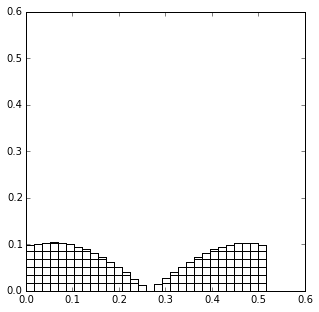

In [37]:
def find_theta(height, hmap_x, hmap_y, eps=0.05):
    thetas = np.linspace(0.1, np.pi/2, 1000)
    dx = hmap_x[1] - hmap_x[0]
    for th in thetas:
        x = arm_length * np.sin(th)
        i = int(np.floor(x / dx))
        y = height - arm_length * np.cos(th)
        e = np.abs(hmap_y[i] - y)
        if e < eps:
            testx = np.arange(0, i)*dx
            cotan_th = 1/np.tan(th)
            A = (- testx*cotan_th + height)
            B = hmap_y[0:i] 
            tests =  A  > B
            if np.alltrue(tests):
                print("Solution for height {} is {} - eps: {} ".format(height, th, e))
                print("x is {}  y is {} - i : {} ".format(x, y, i))
                return th
    return -1

def draw_leg(height, theta):
    end_point = (np.sin(theta)*arm_length, height-arm_length*np.cos(theta))
    plt.plot(end_point[0], end_point[1], 'ro', markersize=3)
    plt.plot([0, end_point[0]], [height, end_point[1]] , 'r-', markersize=3)
    
def draw_one_leg_solution_for_height(height, hmap_x, hmap_y, eps=0.05):
    theta = find_theta(height, hmap_x, hmap_y, eps)
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ax.axis([0, 0.6, 0, 0.6])
    draw_heightmap(ax, heightmapx, heightmapy)
    if theta > 0:
        draw_leg(height, theta)
    else:
        print("not found for height " + str(height))


draw_one_leg_solution_for_height(0.48, heightmapx, heightmapy, eps=0.01 )

In [30]:
def draw_one_leg_solution(hmap_x, hmap_y, eps=0.05):
    min_height = max(np.min(hmap_y), 0.1)
    heights = np.linspace(min_height, np.max(hmap_y)+arm_length, 100)
    heights = heights[::-1]
    theta = -1
    for height in heights:
        theta = find_theta(height, hmap_x, hmap_y, eps)
        if theta >= 0:
            break
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ax.axis([0, 0.6, 0, 0.6])
    draw_heightmap(ax, heightmapx, heightmapy)
    if theta > 0:
        print("solution found: height {} - theta {}".format(height, theta))
        draw_leg(height, theta)

Solution for height 0.651159676282 is 0.960717272945 - eps: 0.00732136028 
x is 0.295056982046  y is 0.444904064611 - i : 23 
solution found: height 0.651159676282 - theta 0.960717272945


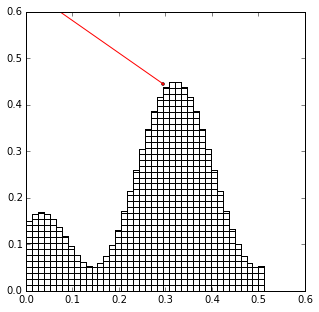

In [15]:
draw_one_leg_solution(heightmapx, heightmapy, eps=0.01)

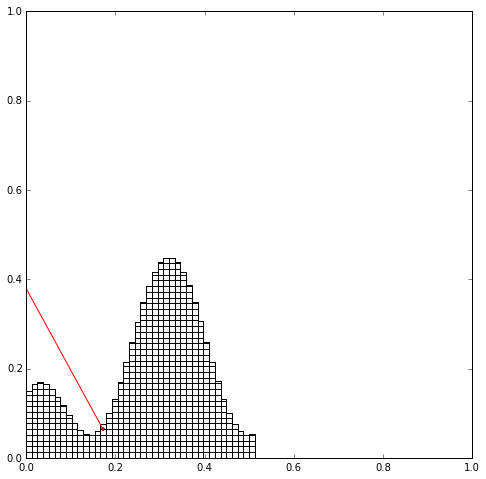

In [16]:
fig = plt.figure(figsize=(8, 8))
ax = plt.gca() 
ax.axis([0, 1, 0, 1])
draw_heightmap(ax, heightmapx, heightmapy)
draw_leg(0.38, 0.5 )

In [17]:
def gen_rand_heightmap():
    ph = random.random()*np.pi/2
    m1 = 0.3 + 0.2*random.random() 
    m2 = 0.1+ 0.1*random.random() 
    m3 = 0.01*random.random() 
    f1 = 3 + random.random() * 5
    f2 = 10 * random.random()*6
    f3 = 10 * random.random()*15
    terrainx =  np.linspace(0, 0.5, 30)
    terrainy = 0.2 * ( np.abs(m1*(np.sin(terrainx*f1+ph) + m2*np.cos(terrainx*f2) + m3*np.cos(terrainx*f3))) )
    return terrainx, terrainy
def plot_rand_terrain():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()
    heightmapx, heightmapy = gen_rand_heightmap()
    ax.axis([0, max(heightmapx), 0, max(heightmapy)+0.1])
    draw_heightmap(ax, heightmapx, heightmapy)

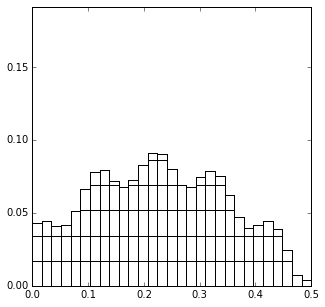

In [18]:
 plot_rand_terrain()

Solution for height 0.430502732219 is 0.1 - eps: 0.00179850049991 
x is 0.0359400299929  y is 0.0723012327191 - i : 2 
solution found: height 0.430502732219 - theta 0.1


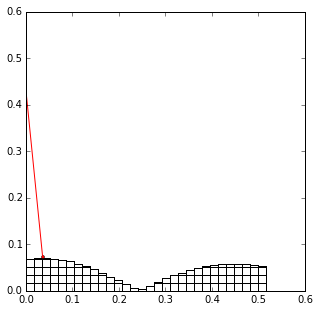

In [41]:
heightmapx, heightmapy = gen_rand_heightmap() 
draw_one_leg_solution(heightmapx, heightmapy, eps=0.01)